In [1]:
import sympy as sym
from sympy import Matrix
import math

from mitroiki_functs import K_truss
from mitroiki_functs import TransformMatrixTruss
from mitroiki_functs import round_expr

import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt

from IPython.display import Image

# Εφαρμογή 9 - Δικτύωμα

Να υπολογιστούν οι αντιδράσεις στήριξης, οι παραμορφώσεις και τo διάγραμμα αξονικών δυνάμεων για τον φορέα του σχήματος.

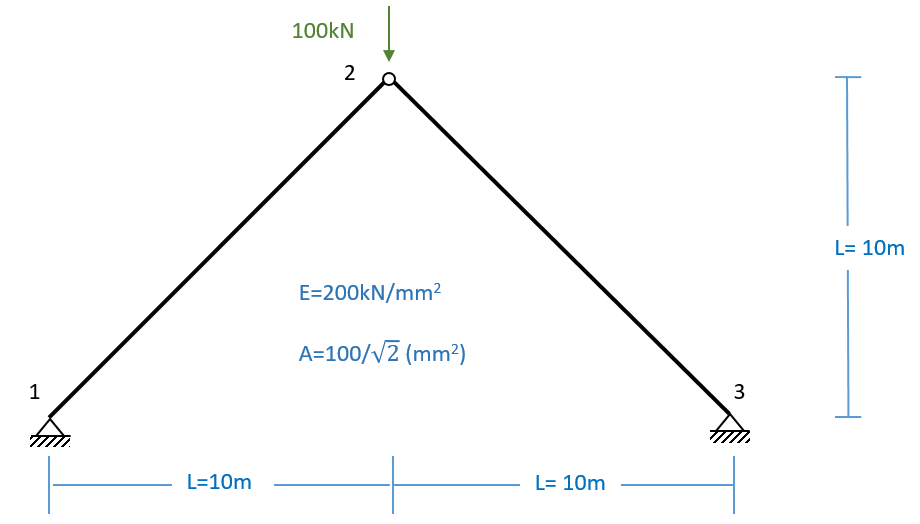

In [2]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example9/ekfonisi.png", width=600)

In [2]:
E = 200_000_000.           # kN/m2
A = 1e-4 / math.sqrt(2)    # m2

L = 10.                    # m

F = 100.                   # kN

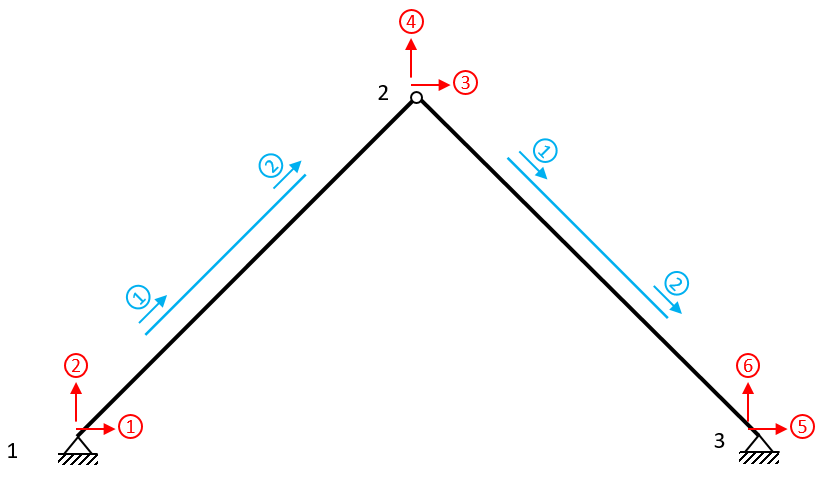

In [4]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example9/dof_global_local.png", width=500)

## Μητρώα στιβαρότητας στοιχείων

In [5]:
K1 = K2 = K_truss(A=A,
                  E=E,
                  L=L*math.sqrt(2))
K1

Matrix([
[ 1000.0, -1000.0],
[-1000.0,  1000.0]])

## Μητρώα μετασχηματισμού και μετατροπή των μητρώων στιβαρότητας

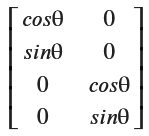

In [6]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/trans_matrix_truss.png", width=120)

In [7]:
Λ1 = TransformMatrixTruss(math.pi/4)
round_expr(Λ1, 4)

Matrix([
[0.7071,      0],
[0.7071,      0],
[     0, 0.7071],
[     0, 0.7071]])

In [8]:
K1_trans = Λ1 * K1 * Λ1.transpose()
K1_trans

Matrix([
[ 500.0,  500.0, -500.0, -500.0],
[ 500.0,  500.0, -500.0, -500.0],
[-500.0, -500.0,  500.0,  500.0],
[-500.0, -500.0,  500.0,  500.0]])

In [9]:
Λ2 = TransformMatrixTruss(-math.pi/4)
round_expr(Λ2, 4)

Matrix([
[ 0.7071,       0],
[-0.7071,       0],
[      0,  0.7071],
[      0, -0.7071]])

In [10]:
K2_trans = Λ2 * K2 * Λ2.transpose()
K2_trans

Matrix([
[ 500.0, -500.0, -500.0,  500.0],
[-500.0,  500.0,  500.0, -500.0],
[-500.0,  500.0,  500.0, -500.0],
[ 500.0, -500.0, -500.0,  500.0]])

Παρατηρείται ότι ενώ τα αρχικά μητρώα στιβαρότητας στο τοπικό σύστημα των ράβδων (μόνο για την αξονική δράση) είναι 2x2, μετά τη χρήση των μητρώων μετασχηματισμού μετατρέπονται σε 4x4, στο καθολικό σύστημα συντεταγμένων)

## Αντιστοίχιση τοπικών - καθολικών βαθμών ελευθερίας

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) |
|--------------|-----|-----|-----|-----|-----|-----|
| 1-2          |  1  |  2  |  3  |  4  |     |     | 
| 2-3          |     |     |  1  |  2  |  3  |  4  |  

In [11]:
K2global = Λ1 * K1 * Λ1.transpose()
K2global

Matrix([
[ 500.0,  500.0, -500.0, -500.0],
[ 500.0,  500.0, -500.0, -500.0],
[-500.0, -500.0,  500.0,  500.0],
[-500.0, -500.0,  500.0,  500.0]])

In [12]:
K1_temp = sym.zeros(6,6)
K1_temp[:4, :4] += K1_trans
round_expr(K1_temp, 1)

Matrix([
[ 500.0,  500.0, -500.0, -500.0, 0, 0],
[ 500.0,  500.0, -500.0, -500.0, 0, 0],
[-500.0, -500.0,  500.0,  500.0, 0, 0],
[-500.0, -500.0,  500.0,  500.0, 0, 0],
[     0,      0,      0,      0, 0, 0],
[     0,      0,      0,      0, 0, 0]])

In [13]:
K2_temp = sym.zeros(6,6)
K2_temp[2:, 2:] += K2_trans
round_expr(K2_temp, 1)

Matrix([
[0, 0,      0,      0,      0,      0],
[0, 0,      0,      0,      0,      0],
[0, 0,  500.0, -500.0, -500.0,  500.0],
[0, 0, -500.0,  500.0,  500.0, -500.0],
[0, 0, -500.0,  500.0,  500.0, -500.0],
[0, 0,  500.0, -500.0, -500.0,  500.0]])

In [14]:
K = K1_temp + K2_temp
round_expr(K, 1)

Matrix([
[ 500.0,  500.0, -500.0, -500.0,      0,      0],
[ 500.0,  500.0, -500.0, -500.0,      0,      0],
[-500.0, -500.0, 1000.0,      0, -500.0,  500.0],
[-500.0, -500.0,      0, 1000.0,  500.0, -500.0],
[     0,      0, -500.0,  500.0,  500.0, -500.0],
[     0,      0,  500.0, -500.0, -500.0,  500.0]])

## Μητρώο εξωτερικής φόρτισης

Η εξωτερική φόρτιση αποτελείται από το επικόμβιο φορτίο στον κόμβο 2 

In [15]:
P = Matrix([[0],
            [0],
            [0],
            [-F],
            [0],
            [0]])

P

Matrix([
[     0],
[     0],
[     0],
[-100.0],
[     0],
[     0]])

## Δεσμευμένοι και ελεύθεροι βαθμοί ελευθερίας

Οι δεσμευμένοι βαθμοί ελευθερίας (με κόκκινο) οφείλονται στις στηρίξεις στους κόμβους 1 και 3, ενώ οι βαθμοί ελευθερίας 3-4 είναι αδέσμευτοι.

## Διαχωρισμός μητρώων

| Καθολ. Συστ. | <span style="color:red">(1)</span>  | <span style="color:red">(2)</span> | <span style="color:blue">(3)</span> | <span style="color:blue">(4)</span>  | <span style="color:red">(5)</span>  | <span style="color:red">(6)</span>  |
|--------------|-----|-----|-----|-----|-----|-----|
| 1-2          |  1  |  2  |  3  |  4  |     |     |
| 2-3          |     |     |  1  |  2  |  3  |  4  |


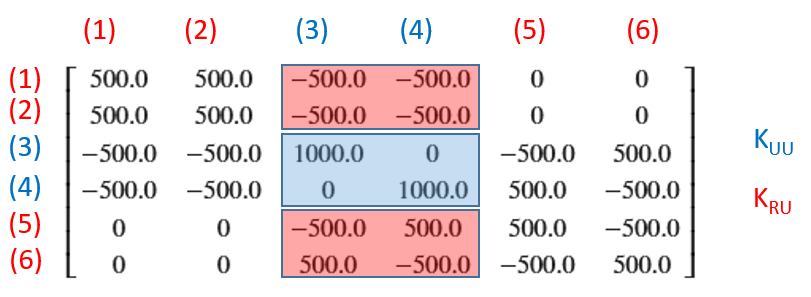

In [16]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example9/Kuu_vs_Kru.png", width=800)

Ομοίως και για τα μητρώα εξωτερικής φόρτισης, παραμορφώσεων και αντιδράσεων

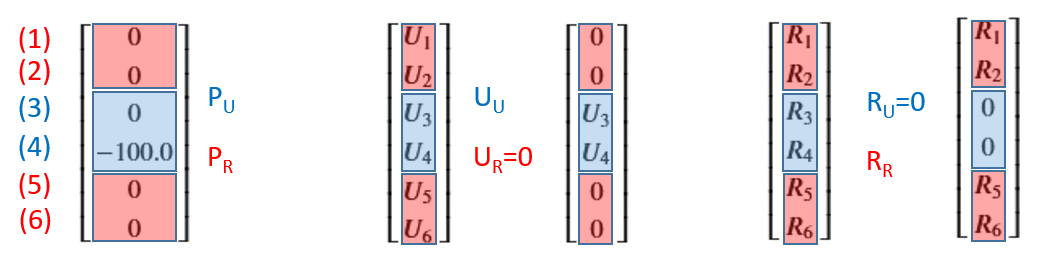

In [17]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example9/PUR.png", width=700)

### Υπομητρώα στιβαρότητας

In [18]:
K_UU = K[[2, 3], [2, 3]]
round_expr(K_UU, 1)

Matrix([
[1000.0,      0],
[     0, 1000.0]])

In [19]:
K_RU = K[[0, 1, 4, 5], [2, 3]]
round_expr(K_RU, 1)

Matrix([
[-500.0, -500.0],
[-500.0, -500.0],
[-500.0,  500.0],
[ 500.0, -500.0]])

### Υπομητρώα εξωτερικής φόρτισης

In [20]:
P_U = P[[2, 3], 0]
round_expr(P_U, 2)

Matrix([
[     0],
[-100.0]])

In [21]:
P_R = P[[0, 1, 4, 5], 0]
round_expr(P_R, 2)

Matrix([
[0],
[0],
[0],
[0]])

## Υπολογισμός παραμορφώσεων

Είναι $K_{UU}\cdot U_U = P_U + R_U$, με $R_U=0$

οπότε $K_{UU}\cdot U_U = P_U$

και τελικά $U_U = K_{UU}^{-1}\cdot P_U$

In [22]:
U_U = K_UU.inv() * P_U
round_expr(U_U, 7)

Matrix([
[   0],
[-0.1]])

## Υπολογισμός αντιδράσεων στήριξης

Είναι $K_{RU}\cdot U_U = P_R + R_R$

οπότε $R_R = K_{RU}\cdot U_U - P_R$

In [23]:
R_R = K_RU*U_U - P_R
round_expr(R_R, 2)

Matrix([
[ 50.0],
[ 50.0],
[-50.0],
[ 50.0]])

## Επίλυση/έλεγχος με το OpenSees

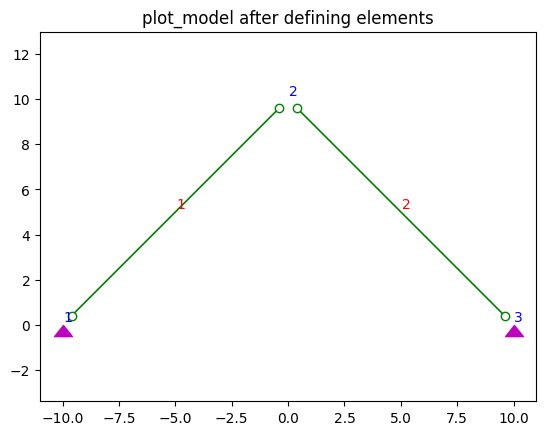

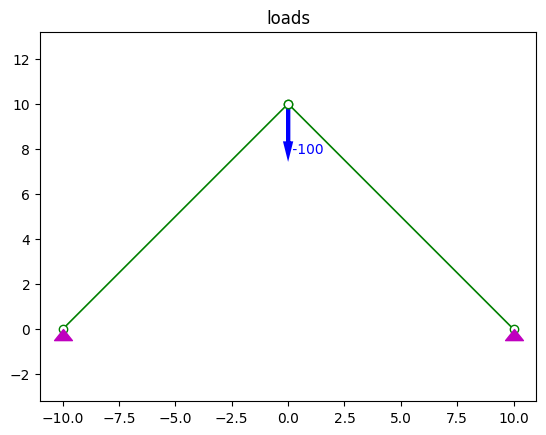

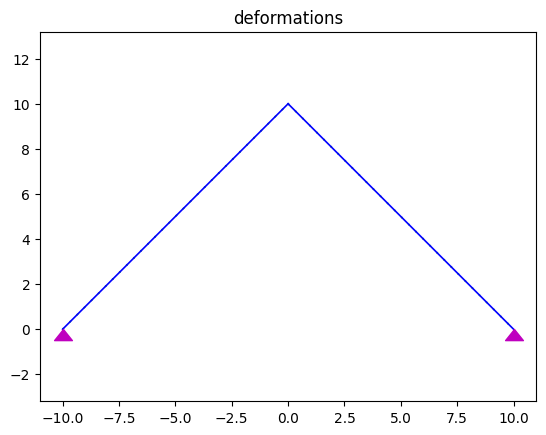

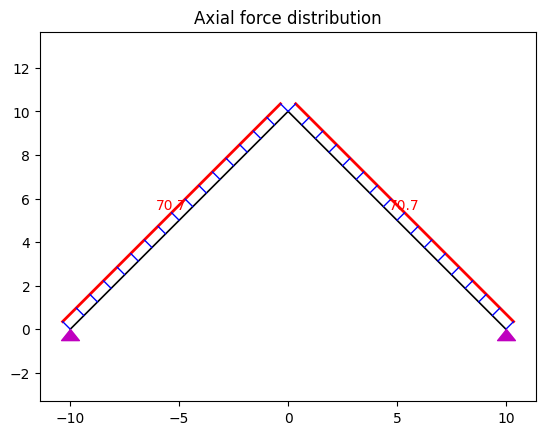

In [24]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 2)

ops.node(1, -L, 0)
ops.node(2, 0, L)
ops.node(3, L, 0)

ops.fix(1, 1, 1)
ops.fix(3, 1, 1)

# define materials
ops.uniaxialMaterial("Elastic", 1, E)

# ops.geomTransf('Linear', 1)

# elements
ops.element('Truss', 1, 1, 2, A, 1)
ops.element('Truss', 2, 2, 3, A, 1)


# loads
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

ops.load(2, 0, -F)

# analysis
ops.constraints('Plain')
ops.numberer('RCM')
ops.system('BandSPD')
# ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.integrator('LoadControl', 1.0)
ops.algorithm('Linear')
ops.analysis('Static')
ops.analyze(1)

# results
# ops.printModel()
opsv.plot_model()
plt.title('plot_model after defining elements')

opsv.plot_loads_2d()
plt.title('loads')

sfac = .01
opsv.plot_defo(sfac)
plt.title('deformations')

sfacN, sfacV, sfacM = 7.e-3, 6.e-3, 4.e-3
opsv.section_force_diagram_2d('N', sfacN)
plt.title('Axial force distribution')

plt.show()


In [25]:
for i in range(1,4):
    print(ops.nodeDisp(i))

[0.0, 0.0]
[0.0, -0.10000000000000003]
[0.0, 0.0]


In [26]:
# U1, U2, U3, U4, U5, U6 = sym.symbols('U1 U2 U3 U4 U5 U6')
# P1, P2, P3, P4, P5, P6 = sym.symbols('P1 P2 P3 P4 P5 P6')
# R1, R2, R3, R4, R5, R6 = sym.symbols('R1 R2 R3 R4 R5 R6')

In [27]:
# U = Matrix([[U1], [U2], [U3], [U4], [U5], [U6]])
# U

In [28]:
# U.subs(U1, 0).subs(U2, 0).subs(U5, 0).subs(U6, 0)

In [29]:
# R = Matrix([[R1], [R2], [R3], [R4], [R5], [R6]])
# R

In [30]:
# R.subs(R3, 0).subs(R4, 0)

In [31]:
# Λ = Matrix([['cosθ', 0], ['sinθ', 0], [0, 'cosθ'], [0, 'sinθ']])
# Λ